# DEMO theory

This notebook is a walkthrough of the theory code

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb

from copy      import deepcopy
from itertools import product

from theory_code.distance_theory import TheoryCalcs

#Plotting
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

red    = '#8e001c'
yellow = '#ffb302'

sidelegend = {'bbox_to_anchor': (1.04,0.5), 
              'loc': "center left",
              'frameon': False}
bottomlegend = {'bbox_to_anchor': (0.35,-0.2), 
                'loc': "center left",
                'frameon': False,
                'ncols': 3}

# Basic cosmology run

This part of the DEMO shows how to get the basic cosmological quantities, with the possibility of including custom cosmological models

## Computational settings

The theory code needs some computational settings to decide the range in redshift where things are computed

In [2]:
settings = {'zmin': 0.001,
            'zmax': 1000.,
            'Nz': 10000}

## Cosmology

This set of parameters computes the basic cosmological ingredients (distances, Hubble parameter, etc...)

This can be done in different ways:

- **Standard:** standard CAMB calculations
- **Custom:** placeholder for custom cosmology

This is specified by the cosmology key passed in the parameters dictionary.

### Standard cosmology

For standard cosmology, the code relies on CAMB and accepts as input the parameters known by this code.
We use the Planck 2018 best fit as a fiducial

In [3]:
standard_params = {'cosmology': 'Standard',
                   'parameters':{'H0': 67.36,
                                 'omch2': 0.1200,
                                 'ombh2': 0.02237,
                                 'omk': 0.,
                                 'mnu': 0.06,
                                 'nnu': 3.}}

### Custom cosmology

This is a placeholder for a possible modified cosmology. The expansion is computed by a custom function (`call_custom` in distance_theory.py)

In this placeholder we work with a toy model where the evolution of the matter density is modified w.r.t. to $\Lambda$CDM

$$
\rho_m(z) = \rho_m^0\,(1+z)^{3+\Delta}
$$

In [14]:
custom_params = {'cosmology': 'Custom',
                 'parameters': {'H0': 67.36,
                                'omegam': 0.3153,
                                'Delta': -0.01}}

### Supernova magnitude model

The code outputs also the apparent magnitude of supernovae as a function of redshift.
This rquires passing a model for the absolute magnitude $M_B$.

Currently, only a constant model is available (but stay tuned)

In [15]:
SNmodel = {'model': 'constant',
           'MB': -19.2435}

## Running the code

In [16]:
standard_results = TheoryCalcs(settings,standard_params,SNmodel,feedback=True)
custom_results   = TheoryCalcs(settings,custom_params,SNmodel,feedback=True)

Running standard CAMB...
CAMB done in 1.11 s
Running custom cosmology...
Custom cosmology done in 0.51 s


/home/Matteo/Projects/GW_projects/DDR/theory_code/distance_theory.py:155: RuntimeWarning: divide by zero encountered in log10
  mB = interp1d(self.zcalc,5*np.log10(dL(self.zcalc))+MB(self.zcalc)+25,kind='linear')


### Output

The output of the theory code is a set of cosmological quantities, returned as attributes of the class

- H_Mpc: $H(z)$ in Mpc$^{-1}$
- H_kmsMpc: $H(z)$ in Km s$^{-1}$ Mpc$^{-1}$
- DM: $D_M=d_C(z)$ (add curvature here)
- DH: $D_H=1/H(z)$
- DV: $D_V=(z\,d_C^2(z)/H(z))^{1/3}$
- dA: $d_A(z)=d_C/(1+z)$
- DL_EM: luminosity distance for EM sources
- DL_GW: luminosity distance for gravitational sources
- comoving: $d_C$
- rdrag: $r_d$ sound horizon at the drag epoch
- omegaL: current value of the dark energy density
- mB: apparent magnitude of SN

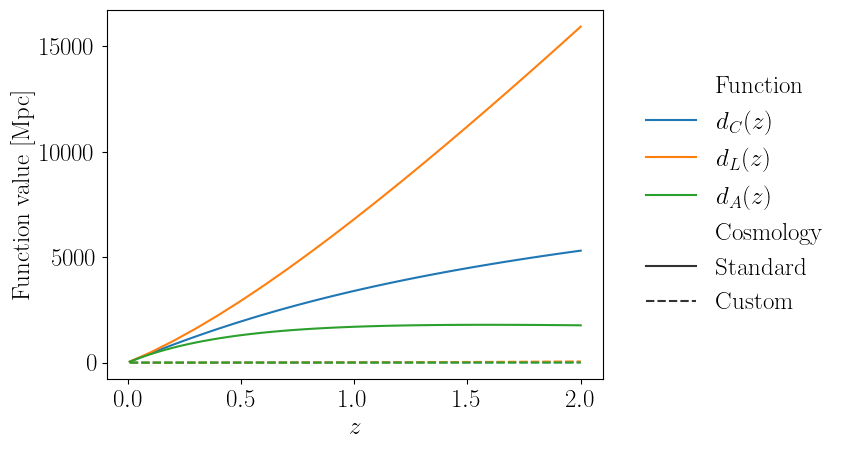

In [17]:
zplot = np.linspace(0.01,2,100)

std_df = pd.DataFrame({'z': zplot,
                       r'$d_C(z)$': standard_results.comoving(zplot),
                       r'$d_L(z)$': standard_results.DL_EM(zplot),
                       r'$d_A(z)$': standard_results.dA(zplot),
                       'Cosmology': 'Standard'})

std_df = pd.melt(std_df,id_vars=['z','Cosmology'],value_vars=[r'$d_C(z)$',r'$d_L(z)$',r'$d_A(z)$'],var_name='Function',value_name='value')

cus_df = pd.DataFrame({'z': zplot,
                       r'$d_C(z)$': custom_results.comoving(zplot),
                       r'$d_L(z)$': custom_results.DL_EM(zplot),
                       r'$d_A(z)$': custom_results.dA(zplot),
                       'Cosmology': 'Custom'})

cus_df = pd.melt(cus_df,id_vars=['z','Cosmology'],value_vars=[r'$d_C(z)$',r'$d_L(z)$',r'$d_A(z)$'],var_name='Function',value_name='value')

results = pd.concat([std_df,cus_df],ignore_index=True)

plt.figure()
sb.lineplot(results,x='z',y='value',hue='Function',style='Cosmology')
plt.xlabel(r'$z$')
plt.ylabel('Function value [Mpc]')
plt.legend(**sidelegend);

# Distance Duality Relation

The code allows to account for deviations from the standard DDR by computing the function

$$
\eta(z)=\frac{d_L(z)}{(1+z)^2d_A(z)}
$$

The parameters controlling this effect are passed through a `DDR` key in the parameters dictionary. If such a key does not exist, the code assumes standard DDR.

The parameterization for this function is:

$$
\eta(z) = (1+a\,z^n)^\epsilon
$$

This function will be used to compute the luminosity distance as

$$
d_L(z) =\eta(z)\,(1+z)^2\,d_A(z)
$$

with $d_A$ computed as above.